# Set-up

In [1]:
from typing import List, NamedTuple, Dict, TypeVar, Tuple
from collections import Counter, defaultdict
import math
import requests
import csv
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import trange
import tqdm

# From scratch

## Vote mechanism

In [2]:
def raw_majority_vote(labels: List[str]) -> str:
    votes = Counter(labels)
    winner, _ = votes.most_common(1)[0]
    return winner

raw_majority_vote(['a','b','c','b'])

'b'

In [3]:
def majority_vote(labels: List[str]) -> str:
    '''Assumes that labels are ordered from nearest to farthest'''
    vote_counts = Counter(labels)
    winner, winner_count = vote_counts.most_common(1)[0]
    num_winners = len([count
                       for count in vote_counts.values()
                       if count == winner_count])
    if num_winners == 1:
        return winner
    else:
        return majority_vote(labels[:-1])

majority_vote(['a','b','c','b','a'])

'b'

## Classifier

In [4]:
Vector = List[float]

def subtract(v: Vector, w: Vector) -> Vector:
    """Subtracts corresponding elements"""
    assert len(v) == len(w), "vectors must be the same length"

    return [v_i - w_i for v_i, w_i in zip(v, w)]
def dot(v: Vector, w: Vector) -> float:
    """Computes v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "vectors must be same length"
    return sum(v_i * w_i for v_i, w_i in zip(v, w))

def sum_of_squares(v: Vector) -> float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def squared_distance(v: Vector, w: Vector) -> float:
    """Computes (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Computes the distance between v and w"""
    return math.sqrt(squared_distance(v, w))

In [5]:
class LabeledPoint(NamedTuple):
    point: Vector
    label: str
    
def knn_classify(k: int, 
                 labeled_points: List[LabeledPoint],
                 new_point: Vector) -> str:
    # Order the labeled points from nearest to farthese
    by_distance = sorted(labeled_points,
                         key = lambda lp: distance(lp.point, new_point))
    # Find the labels for the k closest
    k_nearest_labels = [lp.label for lp in by_distance[:k]]
    # Vote
    return majority_vote(k_nearest_labels)

## Iris example

In [6]:
data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")

with open('iris.data', 'w') as f:
    f.write(data.text)

In [7]:
def parse_iris_row(row: List[str]) -> LabeledPoint:
    '''sepal_length, sepal_width, petal_length, petal_width, class'''
    measurements = [float(value) for value in row[:-1]]
    
    # class is e.g. Iris-virginica, we just want virginica
    label = row[-1].split("-")[1]
    
    return LabeledPoint(measurements, label)

with open("iris.data") as f:
    reader = csv.reader(f, delimiter = ',')
    iris_data = [parse_iris_row(row) for row in reader if len(row) >= 1]
    
points_by_species: Dict[str, List[Vector]] = defaultdict(list)

# group the points by species/label 
for iris in iris_data:
    points_by_species[iris.label].append(iris.point)

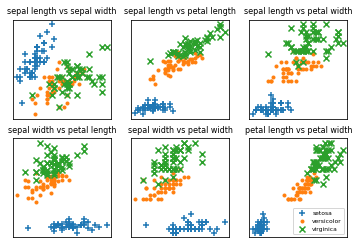

In [8]:
metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize = 8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])
        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker = mark, label = species)
ax[-1][-1].legend(loc = 'lower right', prop = {'size': 6})
plt.show()

In [9]:
X = TypeVar('X')

def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    
    random.shuffle(data)              
    cut = int(len(data) * prob)      
    return data[:cut], data[cut:]     

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.7)

In [10]:
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label
    
    if predicted == actual:
        num_correct += 1
        
    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(pct_correct, confusion_matrix)

0.9777777777777777 defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


## Curse of dimensionality

In [11]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

def random_distance(dim: int, num_pairs: int) -> List[float]:
    return [distance(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)

for dim in tqdm.tqdm(dimensions, desc = 'Curse of Dimensionality'):
    distances = random_distance(dim, 10000)
    
    avg_distances.append(sum(distances) / 10000)
    min_distances.append(min(distances))

min_avg_ratio = [min_dist / avg_dist for min_dist, avg_dist in zip(min_distances, avg_distances)]

Curse of Dimensionality: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


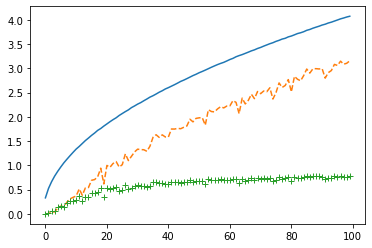

In [12]:
plt.plot([x for x in range(dim)], avg_distances,'-')
plt.plot([x for x in range(dim)], min_distances,'--')
plt.plot(min_avg_ratio,'+')

# Sklearn

In [13]:
from sklearn.neighbors import KNeighborsClassifier